As we did in previous chapters, let's define the default font sizes to make the figures prettier:

In [1]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

And let's creat the `images/dim_reduction` folder (if it doesn't already exist), and define the `save_fig()` function which is used through this notebook to save the figures.

In [2]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "dim_reduction" 
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## PCA  (Principal Components Analysis)--------------------------------

 

In [3]:
import numpy as np
from scipy.spatial.transform import Rotation

m = 60
X = np.zeros((m, 3))  # initialize 3D dataset
np.random.seed(42)
angles = (np.random.rand(m) ** 3 + 0.5) * 2 * np.pi  # uneven distribution
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5  # oval
X += 0.28 * np.random.randn(m, 3)  # add more noise
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X += [0.2, 0, 0.2]  # shift a bit


In [4]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt[0]
c2 = Vt[1]

Note: in principal, the SVD factorization algorithm returns three matrices **U, Σ**and **V**, such that **$X = UΣV^T$**, where **U** is an m*m matrix, **Σ** is an m*n matrix, and **V** is n*n matrix. But the `svd()` function returns **U**, **s** and $V^T$ instead. **s** is the vector containing all the values on the main diagonal of the top *n* rows of **Σ**. Since **Σ** is full of zeros elsewhere, we can easily reconstruct it from **s**, like this:

In [5]:
m, n = X.shape
Σ = np.zeros_like(X_centered)
Σ[:n, :n] = np.diag(s)
assert np.allclose(X_centered, U @ Σ @ Vt)

### Projecting Down to d Dimensions

In [6]:
W2 = Vt[:2].T
X2D = X_centered @ W2

### Using Scikit-Learn  
With Scikit-Learn, PCA is really trivial. It even takes care of mean centering for you:

In [7]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

In [8]:
pca.components_

array([[ 0.67857588,  0.70073508,  0.22023881],
       [ 0.72817329, -0.6811147 , -0.07646185]])

### Explained Variance Ratio
Now let's look at the explained variance ratio:

In [9]:
pca.explained_variance_ratio_

array([0.7578477 , 0.15186921])

The first dimension explains about 76% of the variance, while the second explains about 15%.  

By projecting down to 2D, we lost about 9% of the variance.

In [10]:
1 - pca.explained_variance_ratio_.sum()

0.09028309326742046

### Choosing the Right Number of Dimensions

In [11]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False, parser="auto")
X_train, y_train = mnist.data[:60_000], mnist.target[:60_000]
X_test, y_test = mnist.data[60_000:], mnist.target[60_000:]

pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

Note: I added `parser="auto"` when calling `fetch_openml()` to avoid a warning about the fact that default value for parameter will change in the future (it's irrelevant in this case).

In [12]:
d

154

In [13]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [14]:
pca.n_components_

154

In [15]:
pca.explained_variance_ratio_.sum()

0.9501960192613026

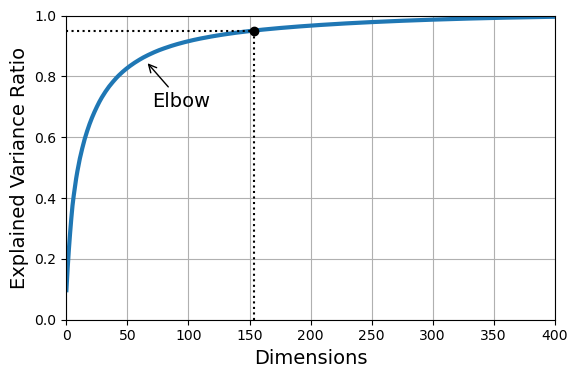

In [16]:
plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance Ratio")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7), arrowprops=dict(arrowstyle="->"))
plt.grid(True)
save_fig("explained_variance_plot")
plt.show()